# Group: 10
# Rollno: 19EE10050, 19EC10041, 22CS60R18
# Project Code: PSSVM
# Project Title: Pulsar Star Classification using Support Vector Machines

# Importing Libraries

In [4]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import pandas
pandas.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
from time import process_time
from tqdm import tqdm

from cvxopt import matrix, solvers

# Preprocessing

In [18]:
class Preprocessor:
  '''Preprocessor'''

  def __init__(self):
    self.means = {}
    self.stds = {}

  def get_folds(self, p_csv, prediction_class):
    '''
        input: processed csv, prediction class
        output: 5 folds
        
        Each fold contains (X_train, y_train, X_test, y_test)
        X_train, X_test are nd-arrays
        y_train, y_test are 1d-arrays
        Usage: see task_1()
    '''
    folds = []
    for train_index, test_index in self.__perform_5_fold(p_csv):
        train_set = p_csv.iloc[train_index]
        test_set = p_csv.iloc[test_index]

        # seperate prediction class from other classes
        X_train, y_train = self.separate_prediction_class(train_set, prediction_class)
        X_test, y_test = self.separate_prediction_class(test_set, prediction_class)

        X_train = X_train.to_numpy()
        y_train = y_train[prediction_class].to_numpy()
        X_test = X_test.to_numpy()
        y_test = y_test[prediction_class].to_numpy()

        folds.append((X_train, y_train, X_test, y_test))
    
    return folds

  def __perform_5_fold(self, dataset):
    '''
        input: train set
        output: generator object which generates one fold indices in one iteration.
    '''

    k_fold = KFold(n_splits=5, shuffle=True, random_state=6)
    for train_index, test_index in k_fold.split(dataset):
        yield train_index, test_index

  def normalize_columns(self, df, prediction_class, test=False):
    '''
        Standardization (Z-score normalization)
        x = (x - mean) / sd
    '''
    for column in df:
      if column == prediction_class:
        ind = (df[column] == 0)
        df[column][ind] = -1
        continue
          
      mean = None
      std = None
      if not test:
        self.means[column] = df[column].mean()
        self.stds[column] = df[column].std()
      mean = self.means[column]
      std = self.stds[column]
      df[column] = (df[column] - mean) / std

  def drop_outliers(self, X_csv, Y_csv):
    limit = {}
    drop_rows = []
    n_columns = len(X_csv.columns)
    for column in X_csv.columns:
      Mean = X_csv[column].mean()
      Std = X_csv[column].std()
      limit[column] = Mean + 3 * Std

    print('limits done')
    for i, row in X_csv.iterrows():
      n_col_outliers = 0
      for column in X_csv.columns:
        if (row[column] > limit[column]):
            n_col_outliers += 1
      if (2 * n_col_outliers > n_columns):
        drop_rows.append(i)
    print('dropping rows...')
    return X_csv.drop(drop_rows), Y_csv.drop(drop_rows)

  def separate_prediction_class(self, dataset, prediction_class):
    '''
        input: prediction class
        output: X df, y df
        Seperates prediction class from other classes
    '''
    Y = dataset[[prediction_class]]
    X = dataset.drop([prediction_class], axis=1)
    return X, Y

  def process(self, csv_file, prediction_class):
    '''
        input: raw csv file
        output: prcessed csv (dataframe)
        1. Normalizes features [0,1]
        Usage:
            p = Preprocessor()
            p_csv = p.process('hospital.csv', 'Stay')
    '''
    # read input
    df = pandas.read_csv(csv_file)

    # 14319 rows required 1.6GB of memory to store Kernel Matrix
    df = df.iloc[:10000, :]

    # split dataset into train and test
    train, test = train_test_split(df, test_size=0.2, random_state=6)

    # normalize columns
    self.normalize_columns(train, prediction_class)
    self.normalize_columns(test, prediction_class, test=True)

    # separate prediction class
    X_train, Y_train = Preprocessor().separate_prediction_class(train, 'Class')
    X_test, Y_test = Preprocessor().separate_prediction_class(test, 'Class')

    return X_train, Y_train.iloc[:, 0], X_test, Y_test.iloc[:, 0]

# custom SVM

In [19]:
class SVM:

  def __init__(self, kernel='linear', C=1.0, gamma=0.125):
    self.kernel = kernel
    self.C = C
    self.gamma = gamma
    self.alphas = None
    self.weights = None
    self.bias = None
    self.support_vectors = []

  def kernel_function(self, x1, x2):
    if self.kernel == 'linear':
      return np.dot(x1, x2)

    elif self.kernel == 'quadratic':
      return (np.dot(x1, x2)+1) ** 2 

    else:
      dist = np.dot((x1 - x2).T, (x1 - x2))
      K = np.exp(-self.gamma * dist)
      return K

  def calculate_weights(self, alphas, x, y):
    y = y.reshape(-1,1) # Convert the y into same form as alphas... dim(alphas) : m * 1
    w = ((y*alphas).T)@x
    return w

  def calculate_bias(self, w, x_sv, y_sv):
    return (y_sv - np.dot(x_sv,w))

  def qp_solver(self, x, y):
    m, n = x.shape # m : no. of examples in training data, n : no. of attributes in training data
    K = np.zeros((m, m))
    for i in tqdm(range(m)):
      for j in range(i, m):
        K[i][j] = self.kernel_function(x[i], x[j])
        K[j][i] = K[i][j] # symmetric kernel function

    y = y.astype(float)
    coeff = np.outer(y,y)
    P = matrix(coeff * K)
    q = matrix(np.ones((m, 1)) * -1)
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    G = matrix(np.vstack((np.eye(m)*-1, np.eye(m))))
    h = matrix(np.hstack((np.zeros(m), np.ones(m) * self.C)))
    opts = {'maxiters' : 10, 'show_progress' : True}
    solution = solvers.qp(P, q, G, h, A, b, options=opts)
    return solution

  def fit(self, X_train, y_train):
    print("--------------------------------Training--------------------------------")
    t1 = process_time()
    x, y = X_train.to_numpy(), y_train.to_numpy()
    print('dataset size: {}, dimension: {}'.format(len(x), len(x[0])))

    sol = self.qp_solver(x, y)
    alphas = np.array(sol['x'])

    sv = (alphas > 1e-6).flatten() # support vectors indices
    x_sv = x[sv]
    y_sv = y[sv]

    weights = self.calculate_weights(alphas, x, y) # Using the entire dataset to calculate weights
    b = self.calculate_bias(weights[0], x_sv, y_sv) # Using only the support vectors to calculate b vector
    bias = np.sum(b)/b.size  # Take average over all the support vectors to get the bias

    for p in x:
      value = np.abs(np.dot(weights, p) + bias)
      if value >= 0.9 and value <= 1 + 1e-15:
        self.support_vectors.append(p)
    self.support_vectors = np.array(self.support_vectors)

    t2 = process_time()

    print('\nResults ')
    print('Weights: ', weights)
    print('Bias: ', bias)
    print("\nTraining Time: ", t2 - t1)
    print("------------------------------------------------------------------------")

    self.weights = weights
    self.bias = bias
    self.alphas = alphas
    return weights, bias

  def predict(self, X_test):
    X_test = X_test if isinstance(X_test, np.ndarray) else X_test.to_numpy()
    y_pred = []
    for x in X_test:
      if np.dot(self.weights, x) + self.bias > 0:
        y_pred.append(1)
      else:
        y_pred.append(-1)
    return y_pred    

  def score(self, y_test, y_pred):
    print("\nAccuracy: ", accuracy_score(y_test.to_list(), y_pred)) # Accuracy

# Helper Function

In [7]:
def train(kernel='linear', C=1.0, gamma=0.125, is_sklearn=True):
  kernel = 'poly' if (is_sklearn == True and kernel == 'quadratic') else kernel
  model = svm.SVC(C=C, kernel=kernel, degree=2, gamma=gamma) if (is_sklearn == True) else SVM(kernel=kernel, C=C, gamma=gamma)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print('\nAccuracy: ', accuracy)

# Model Training

In [8]:
X_train, y_train, X_test, y_test = Preprocessor().process("pulsar_star_dataset.csv", "Class")

### custom SVM

In [ ]:
'''
  Note : kernel takes 3 types of values
          1. 'linear'
          2. 'quadratic'
          3. 'rbf'
'''

train(kernel='quadratic', C=0.01, gamma=0.0001, is_sklearn=False)

--------------------------------Training--------------------------------
dataset size: 8000, dimension: 8


100%|██████████| 8000/8000 [02:06<00:00, 63.35it/s] 


     pcost       dcost       gap    pres   dres
 0: -3.9481e+02 -1.7220e+02  7e+04  3e+02  4e-12
 1: -1.4026e+01 -1.7058e+02  2e+03  5e+00  4e-12
 2: -6.3531e+00 -1.2437e+02  2e+02  6e-01  4e-13
 3: -4.9811e+00 -4.9401e+01  7e+01  1e-01  1e-13
 4: -4.6936e+00 -2.9873e+01  4e+01  7e-02  7e-14
 5: -4.5296e+00 -1.5906e+01  1e+01  2e-02  4e-14
 6: -4.5806e+00 -1.2511e+01  1e+01  1e-02  3e-14
 7: -4.7237e+00 -9.1942e+00  5e+00  7e-03  3e-14
 8: -4.7581e+00 -8.6170e+00  4e+00  5e-03  2e-14
 9: -4.8784e+00 -7.4501e+00  3e+00  3e-03  3e-14
10: -4.9277e+00 -7.0579e+00  2e+00  2e-03  2e-14
Terminated (maximum number of iterations reached).

Results 
Weights:  [[-0.14363432 -0.00569486  0.46124721  0.16034185 -0.00124281  0.15531993
  -0.00909904 -0.0430507 ]]
Bias:  -0.7191147467148985

Training Time:  782.3380268279999
------------------------------------------------------------------------

Accuracy:  0.966


In [ ]:
'''
  Best performing configuration among the grid search
'''
train(kernel='quadratic', C=0.1, gamma=0.001, is_sklearn=False)

--------------------------------Training--------------------------------
dataset size: 8000, dimension: 8


100%|██████████| 8000/8000 [02:07<00:00, 62.89it/s] 


     pcost       dcost       gap    pres   dres
 0: -4.2992e+02 -1.7260e+03  7e+04  3e+01  5e-12
 1: -6.8810e+01 -1.5902e+03  4e+03  1e+00  4e-12
 2: -4.8594e+01 -7.1670e+02  1e+03  2e-01  1e-12
 3: -4.2691e+01 -3.6103e+02  5e+02  1e-01  5e-13
 4: -4.0174e+01 -2.1171e+02  2e+02  4e-02  3e-13
 5: -3.9973e+01 -1.1448e+02  9e+01  1e-02  3e-13
 6: -4.0638e+01 -9.6603e+01  7e+01  8e-03  3e-13
 7: -4.1620e+01 -8.3640e+01  5e+01  5e-03  3e-13
 8: -4.2910e+01 -7.0750e+01  3e+01  3e-03  3e-13
 9: -4.3430e+01 -6.4749e+01  2e+01  2e-03  3e-13
10: -4.3839e+01 -6.2170e+01  2e+01  1e-03  3e-13
Terminated (maximum number of iterations reached).

Results 
Weights:  [[-0.09907274  0.04088952  1.06073124  0.30312745 -0.0327353   0.3721796
   0.15243164 -0.02457808]]
Bias:  -0.7469999999999999

Training Time:  782.2728920039999
------------------------------------------------------------------------

Accuracy:  0.97


In [ ]:
train(kernel='quadratic', C=1, gamma=0.01, is_sklearn=False)

--------------------------------Training--------------------------------
dataset size: 8000, dimension: 8


100%|██████████| 8000/8000 [02:05<00:00, 63.71it/s] 


     pcost       dcost       gap    pres   dres
 0: -7.8041e+02 -1.8278e+04  1e+05  3e+00  8e-12
 1: -5.0782e+02 -1.1001e+04  2e+04  5e-01  7e-12
 2: -4.0915e+02 -3.8681e+03  6e+03  1e-01  4e-12
 3: -3.8396e+02 -2.6484e+03  3e+03  6e-02  3e-12
 4: -3.7349e+02 -1.8686e+03  2e+03  3e-02  3e-12
 5: -3.7524e+02 -1.3438e+03  1e+03  2e-02  3e-12
 6: -3.6977e+02 -1.2345e+03  1e+03  1e-02  3e-12
 7: -3.8385e+02 -9.1242e+02  6e+02  6e-03  3e-12
 8: -3.9365e+02 -7.9665e+02  5e+02  3e-03  3e-12
 9: -4.0241e+02 -7.0701e+02  3e+02  2e-03  3e-12
10: -4.0449e+02 -6.8606e+02  3e+02  2e-03  3e-12
Terminated (maximum number of iterations reached).

Results 
Weights:  [[-0.06341606  0.09882451  1.73987039  0.3266624   0.01946113  0.74815624
   0.56340283 -0.15817231]]
Bias:  -0.733159277168465

Training Time:  789.1631975190003
------------------------------------------------------------------------

Accuracy:  0.9555


In [ ]:
train(kernel='quadratic', C=10, gamma=0.1, is_sklearn=False)

--------------------------------Training--------------------------------
dataset size: 8000, dimension: 8


100%|██████████| 8000/8000 [02:02<00:00, 65.26it/s] 


     pcost       dcost       gap    pres   dres
 0: -4.2232e+03 -4.8676e+05  1e+06  8e-01  4e-11
 1: -3.5061e+03 -1.8087e+05  3e+05  1e-01  4e-11
 2: -3.1917e+03 -1.1267e+05  2e+05  6e-02  3e-11
 3: -2.9957e+03 -6.6851e+04  9e+04  3e-02  2e-11
 4: -2.9311e+03 -6.2336e+04  8e+04  2e-02  2e-11
 5: -2.8197e+03 -5.1528e+04  6e+04  1e-02  2e-11
 6: -2.8465e+03 -3.8993e+04  4e+04  5e-03  2e-11
 7: -3.1497e+03 -1.9507e+04  2e+04  2e-03  3e-11
 8: -3.2275e+03 -1.8304e+04  2e+04  1e-03  3e-11
 9: -3.3736e+03 -1.4832e+04  1e+04  7e-04  3e-11
10: -3.4648e+03 -1.2904e+04  1e+04  5e-04  3e-11
Terminated (maximum number of iterations reached).

Results 
Weights:  [[-8.00579074e-01  1.33622582e-03  4.87024066e+00 -1.54324648e+00
   1.05224240e-01  2.32037673e+00  2.08727492e+00 -1.06082535e+00]]
Bias:  -0.7469999999999994

Training Time:  782.6785862030001
------------------------------------------------------------------------

Accuracy:  0.8905


In [ ]:
train(kernel='quadratic', C=100, gamma=1, is_sklearn=False)

--------------------------------Training--------------------------------
dataset size: 8000, dimension: 8


100%|██████████| 8000/8000 [02:06<00:00, 63.40it/s] 


     pcost       dcost       gap    pres   dres
 0: -3.2434e+04 -3.8148e+07  1e+08  6e-01  4e-10
 1: -1.9586e+04 -1.3550e+07  2e+07  9e-02  4e-10
 2: -1.5852e+04 -8.7366e+06  1e+07  5e-02  3e-10
 3: -1.3575e+04 -5.3762e+06  7e+06  2e-02  2e-10
 4: -1.0867e+04 -5.2521e+06  7e+06  2e-02  2e-10
 5: -5.8145e+03 -4.3365e+06  5e+06  1e-02  2e-10
 6: -3.1125e+03 -3.5925e+06  4e+06  7e-03  2e-10
 7: -1.6923e+04 -1.5687e+06  2e+06  2e-03  2e-10
 8: -2.7676e+04 -3.7683e+05  4e+05  9e-05  3e-10
 9: -3.0611e+04 -2.3683e+05  2e+05  4e-05  2e-10
10: -3.2164e+04 -1.9132e+05  2e+05  2e-05  2e-10
Terminated (maximum number of iterations reached).

Results 
Weights:  [[-2.03912478 -0.61625561 10.24102359 -7.41508125  3.57922238  3.53218827
   7.23187661 -5.23352072]]
Bias:  -0.7469999999999991

Training Time:  799.8701884110005
------------------------------------------------------------------------

Accuracy:  0.8165


### sklearn SVM

In [9]:
'''
  Note : kernel takes 3 types of values
          1. 'linear'
          2. 'quadratic'
          3. 'rbf'
'''

train(kernel='quadratic', C=0.1, gamma=0.125, is_sklearn=True)


Accuracy:  0.964


# Visualization

### Helper Functions

In [20]:
def make_meshgrid(x, y, h=.02):
  x_min, x_max = x.min() - 1, x.max() + 1
  y_min, y_max = y.min() - 1, y.max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  return xx, yy

In [21]:
def plot_contours(ax, clf, xx, yy, is_sklearn=False, **params):
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape) if is_sklearn == True else np.array(Z).reshape(xx.shape)
  out = ax.contourf(xx, yy, Z, **params)
  return out

In [22]:
def visualize_boundary(kernel='linear', C=1, gamma=0.125, is_sklearn=True):
    X_train, y_train, X_test, y_test = Preprocessor().process("pulsar_star_dataset.csv", "Class")
    columns = [2, 5]
    X_train = X_train.iloc[:, columns]
    X_test = X_test.iloc[:, columns]

    model = svm.SVC(kernel='poly' if kernel=='quadratic' else kernel, C=C, gamma=gamma, degree=2) if (is_sklearn == True) \
           else SVM(kernel=kernel, C=C, gamma=gamma)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy)

    title = "SVM with " + kernel + " kernel"
    
    X0, X1 = X_train.iloc[:, 0], X_train.iloc[:, 1]
    y = y_train

    # Set-up 2x2 grid for plotting.
    fig, ax = plt.subplots()

    # setup grid
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    
    # support vectors
    support_vector_indices = None
    v = None
    if is_sklearn:
        # obtain the support vectors through the decision function
        decision_function = model.decision_function(X_train)
        A = np.where(np.abs(decision_function) <= 1 + 1e-15)
        B = np.where(np.abs(decision_function) > 0.9)
        support_vector_indices = np.intersect1d(A, B)
        v = X_train.to_numpy()[support_vector_indices]
    else:
        v = model.support_vectors
    
    ax.scatter(v.T[0], v.T[1], color=['white' for i in range(len(v))], s=20, edgecolors='k')

    ax.set_ylabel(X_train.columns[0])
    ax.set_xlabel(X_train.columns[1])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    ax.legend()
    plt.show()

### custom SVM

--------------------------------Training--------------------------------
dataset size: 8000, dimension: 2


100%|██████████| 8000/8000 [02:31<00:00, 52.84it/s]  


     pcost       dcost       gap    pres   dres
 0: -5.6239e+02 -1.7229e+03  7e+04  3e+01  6e-13
 1: -9.5814e+01 -1.5907e+03  5e+03  2e+00  5e-13
 2: -6.1497e+01 -7.4744e+02  1e+03  2e-01  1e-13
 3: -4.9520e+01 -2.5931e+02  3e+02  6e-02  6e-14
 4: -4.6934e+01 -1.6184e+02  1e+02  3e-02  5e-14
 5: -4.8193e+01 -1.0166e+02  6e+01  1e-02  5e-14
 6: -4.9275e+01 -8.3415e+01  4e+01  5e-03  5e-14
 7: -5.0187e+01 -7.4893e+01  3e+01  4e-03  4e-14
 8: -5.0636e+01 -7.0386e+01  2e+01  2e-03  4e-14
 9: -5.1290e+01 -6.3785e+01  1e+01  9e-04  5e-14
10: -5.1832e+01 -5.9951e+01  8e+00  3e-04  5e-14
Terminated (maximum number of iterations reached).

Results 
Weights:  [[0.90384047 0.27132782]]
Bias:  -0.747

Training Time:  942.789459097
------------------------------------------------------------------------
0.966


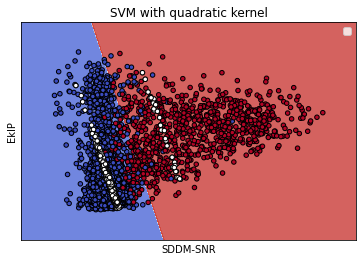

In [23]:
# visualize_boundary(kernel= <desired kernel here>, C=<desired C here>, gamma = <desired C here>, is_sklearn=True)
visualize_boundary(kernel='quadratic', C=0.1, is_sklearn=False)

### sklearn SVM

0.958


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


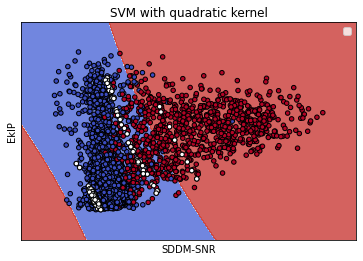

In [11]:
# visualize_boundary(kernel= <desired kernel here>, C=<desired C here>, gamma = <desired C here>, is_sklearn=True)
visualize_boundary(kernel='quadratic', C=0.1, is_sklearn=True)